For Mankind to succeed we must eliminate uncertainty. To eliminate uncertainty we must master chaos.

# Import Packages

In [18]:
import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objs as go         
import plotly.express as px
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from timeit import timeit
from sklearn.metrics import mean_squared_error
from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (14, 8)

# Helpful Functions

In [2]:
def sameSigns(x,y):
    if x*y >= 0:
        flag = True
    else:
        flag = False
        
    return flag

def rmse(x,y):
    return mean_squared_error([x],[y], squared=False)

def calculateAccuracy(asset, w):
    x = len(asset.forecastingDataFrame[w:-1])
    y = sum(asset.forecastingDataFrame['Decision'][w:-1])
    print("Accuracy of this experiment is", (y/x)*100, "%")

def hoursNYSE(time):
    hours = int(time[0:2])
    mins = int(time[3:5])
    secs = int(time[6:8])
    
    if hours >= 14 and hours < 21:
        if (hours == 14 and mins < 30):
            marketOpen = False
        else:
            marketOpen = True
    else:
        marketOpen = False
    
    return marketOpen

# Classes

## Initial Attributes:

##### • Ticker - Stat that represents the dynamic price of an asset. Most common stock have a unique 'ticker'.
##### • Start - The start date for the model.
##### • End - The ending date for the model.
##### • Source - The source from which the data is scraped.

In [3]:
class Asset:
    def __init__(self, ticker, start=(2010,1,1), end='NOW', source='yahoo'):
        self.ticker = ticker
        self.start = dt.datetime(*start)
        if end == 'NOW':
            self.end = dt.datetime.now()
        else:
            self.end = dt.datetime(*end)
        self.currentTime = dt.datetime.now().strftime("%H:%M:%S")
        self.source = 'yahoo'
        self.perchange = pdr.DataReader(self.ticker, self.source, self.start, self.end)
        self.perchange['Daily_Return'] = self.perchange['Adj Close'].pct_change()
        self.original = self.perchange.drop(columns=['High','Low','Open','Close','Volume', 'Adj Close']).iloc[1:]
        self.len = len(self.original)
        
    def plot(self, title):
        plt.title(title)
        plt.plot(self.original)
        
    def forecast_with_window(self, w_0, w_1, explain=False):
        self.w_0 = w_0
        self.w_1 = w_1
        self.trainingDataFrame = self.original.copy()
        self.trainDF = self.trainingDataFrame.iloc[self.w_0:self.w_1]
        self.testDF = self.trainingDataFrame.iloc[self.w_1+1]
        self.currentCalibration = auto_arima(self.trainDF)
        self.model = ARIMA(self.trainDF, order = self.currentCalibration.order).fit()
        self.currentPrediction = self.model.predict(start=len(self.trainDF), end=len(self.trainDF), typ='levels')
        self.currentRMSE = pd.Series(data = {'RMSE': rmse(self.currentPrediction, self.testDF)})
        
        if explain == True:
            print("We predict that the next day will give a return of", round(float(self.currentPrediction), 6), ", it was actually",
              round(float(self.testDF), 6), "\nTherefore, we get an RMSE of", round(float(self.currentRMSE), 6))
            
    def initFDF(self):
        self.forecastingDataFrame = self.original.copy()
        self.forecastingDataFrame['Forecast'] = np.nan
        self.forecastingDataFrame['RMSE'] = np.nan
        self.forecastingDataFrame['Decision'] = np.nan
        self.forecastingDataFrame
    
    def displayFDF(self,a,b):
        print(self.forecastingDataFrame[a:b])
        
    def updateToFDF(self):        
        self.forecastingDataFrame['Forecast'].iloc[self.w_1] = float(self.currentPrediction)
        self.forecastingDataFrame['RMSE'].iloc[self.w_1] = self.currentRMSE[0]
        if sameSigns(self.forecastingDataFrame['Daily_Return'].iloc[self.w_1], self.forecastingDataFrame['Forecast'].iloc[self.w_1]):
            self.forecastingDataFrame['Decision'].iloc[self.w_1] = 1
        else:
            self.forecastingDataFrame['Decision'].iloc[self.w_1] = 0
    
    def rollingForecast(self, w):
        self.STOP = False
        self.currentIteration = 0
        self.initFDF()
        self.w0 = 0
        self.w1 = w
        while not self.STOP:
            if self.currentIteration >= self.len - w - 2:
                self.STOP = True
            if self.currentIteration % 100 == 0:
                print(self.currentIteration, "/", self.len - w - 2)
            
            self.forecast_with_window(self.w0, self.w1)
            self.updateToFDF()
            
            self.w0 += 1
            self.w1 += 1
            self.currentIteration += 1
    
    def recursiveForecast(self, w):
        self.STOP = False
        self.currentIteration = 0
        self.initFDF()
        self.w0 = 0
        self.w1 = w
        while not self.STOP:
            if self.currentIteration >= self.len - w - 2:
                self.STOP = True
            if self.currentIteration % 100 == 0:
                print(self.currentIteration, "/", self.len - w - 2)
            
            self.forecast_with_window(self.w0, self.w1)
            self.updateToFDF()
            
            self.w1 += 1
            self.currentIteration += 1
    
    def forecastTomorrow(self, doToday = False):
        if doToday:
            self.tomorrow = dt.date.today()
            self.trainingDataFrame = self.original.iloc[:-1]
        else:
            self.tomorrow = dt.date.today() + dt.timedelta(days=1)
            self.trainingDataFrame = self.original.copy()
        self.tomorrow = self.tomorrow.strftime("%d/%m/%Y, %H:%M:%S")[0:10]
        self.currentCalibration = auto_arima(self.trainingDataFrame)
        self.model = ARIMA(self.trainingDataFrame, order = self.currentCalibration.order).fit()
        self.currentPrediction = self.model.predict(start=len(self.trainingDataFrame), end=len(self.trainingDataFrame), typ='levels')
        
        if float(self.currentPrediction) > 0:
            print(str(self.ticker), "forecast for",self.tomorrow,"\b:", round(float(self.currentPrediction)*100, 6),"%. This indicates we should BUY!")
        else:
            print(str(self.ticker), "forecast for",self.tomorrow,"\b:", round(float(self.currentPrediction)*100, 6),"%. This indicates we should SHORT/SELL!")
        

In [4]:
Image(url="pypl.png", width=300, height=300)

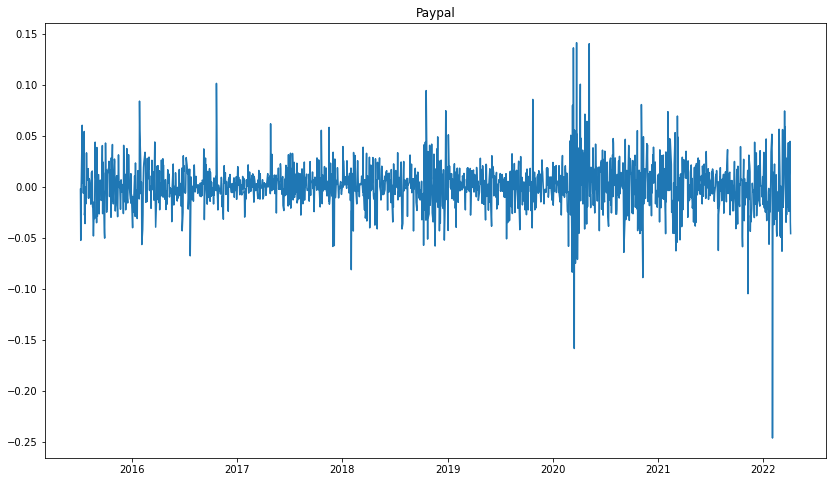

In [5]:
PYPL = Asset('PYPL')
PYPL.plot('Paypal')

In [6]:
Image(url="mcd.png", width=300, height=300)

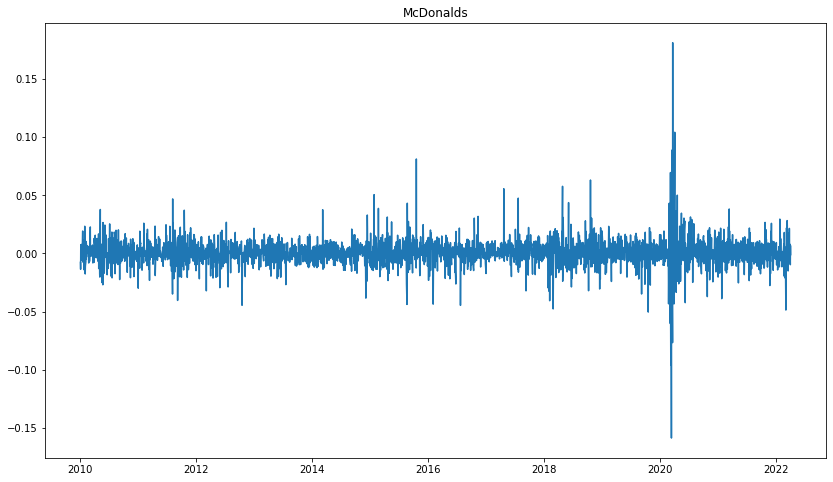

In [7]:
MCD = Asset('MCD')
MCD.plot('McDonalds')

In [8]:
Image(url="aapl.png", width=300, height=300)

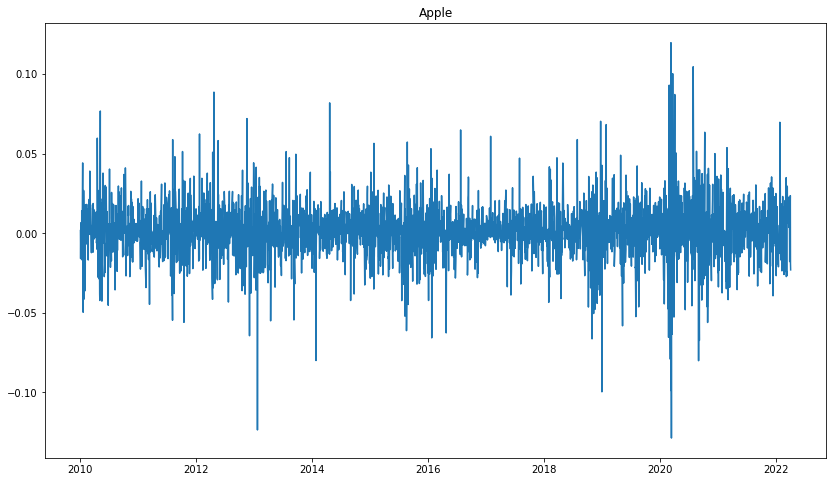

In [9]:
AAPL = Asset('AAPL')
AAPL.plot('Apple')

In [10]:
Image(url="JPM.png", width=300, height=300)

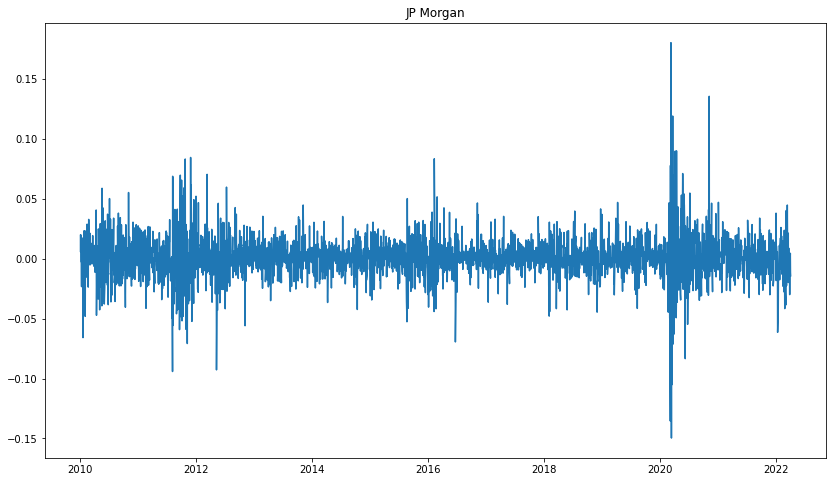

In [11]:
JPM = Asset('JPM')
JPM.plot('JP Morgan')

# Forecasting Analysis

In [ ]:
 ###

## Accuracy of a ROLLING 30-day window since 2010-01-01

### PayPal

AR(5): 49.8494%  <br>
Automatic Calibration: 51.8964%

## Accuracy of a RECURSIVE continuously larger window since 2010-01-01*.

### PayPal

AR(5): 52.4985%  <br>
ARIMA(AIC): 52.4985%

### McDonalds

ARIMA(AIC): 54.9869%

### Apple

ARIMA(AIC): 53.2480%

### J.P.Morgan

ARIMA(AIC): 51.3451%

### Tomorrow's prediction using best model

In [ ]:
PYPL.forecastTomorrow()
MCD.forecastTomorrow()
AAPL.forecastTomorrow()
JPM.forecastTomorrow()

In [ ]:
PYPL.forecastTomorrow(doToday=True)
MCD.forecastTomorrow(doToday=True)
AAPL.forecastTomorrow(doToday=True)
JPM.forecastTomorrow(doToday=True)

# Findings/Logs

23/03/2022: <br> 
• Today we completed our first ARIMA forecasting analysis using PayPal (TICKER: PYPL). | **8:32PM** <br>
• Just based on PAYPAL we are seeing evidence to support that an automatic calibration of ARIMA order is generally <br> better than an AR(5) model. | **11:42PM**

24/03/2022: <br>
• I have now completed tomorrow's forecasts for four different stocks (paying slight attention to diversification). This <br>
includes PayPal, McDonalds, Apple and J.P. Morgan). Haven't done ARIMA forecasting analysis for the last three but will attempt in the morning. | **3:31AM**

30/03/2022: <br>
• Finally completed forecasting analysis of McDonalds, Apple, and JP Morgan. Results seem to further support the use of ARIMA(AIC) for forecasting daily returns with all currently tested assets achieving a greater than 50% correct indication.

# Playground